# Model Output Notebook

<img style="float:center;" src="https://arcticexpansion.vse.gmu.edu/sites/arcticexpansion.vsnet.gmu.edu/files/images/header5d2.png" width=600px>

### ADCIRC-SWAN Output


### Initialize Libraries

In [1]:
import warnings;warnings.filterwarnings("ignore")
import netCDF4 as nc4;        import pandas as pd
import requests;              import json;
import matplotlib as mpl;     import matplotlib.pyplot as plt
import matplotlib.tri as tri; import pathlib as pl
import cartopy.crs as ccrs;   import cartopy.io.img_tiles as cart_img
import cartopy as cart;       import cartopy.io.img_tiles as cimgt
import numpy as np;           
from sklearn.neighbors import BallTree

### Defined Functions

In [2]:
def noaa_data(begin,end,station,vdatum='NAVD',interval='6',
                       form='json',t_zone='GMT',unit='metric',product='water_level'):
    '''
    This function is used to get the data from NOAA API
    :param begin: begin date of the data
    :param end: end date of the data
    :param station: noaa station id
    :param vdatum: vertical datum such as NAVD
    :param interval: interval of the data (6 minutes)
    :param form: format of the data (json)
    :param t_zone: time zone of the data (GMT)
    :param unit: unit of the data (metric)
    :param product: type of the data (water_level)
    '''
    api = f'https://tidesandcurrents.noaa.gov/api/datagetter?begin_date={begin}&end_date={end}&station={station}'\
         f'&product={product}&application=NOS.COOPS.TAC.WL&datum={vdatum}&interval={interval}&time_zone={t_zone}&units={unit}&format={form}'
    data = requests.get(url=api).content.decode()
    return data




def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))
def point_lookup(model_lat:np.array, model_lon:np.array, satellite_lat:float, satellite_lon:float): 
    rad_factor = np.pi/180.0
    modlatrad = model_lat[:] * rad_factor
    modlonrad = model_lon[:] * rad_factor
    ny,nx = modlatrad.shape, modlonrad.shape
    clat,clon = np.cos(modlatrad),np.cos(modlonrad)
    slat,slon = np.sin(modlatrad),np.sin(modlonrad)
    triples = list(zip(np.ravel(clat*clon), np.ravel(clat*slon), np.ravel(slat)))
    kdt = cKDTree(triples)
    #feeding the desired point
    satlatrad = satellite_lat * rad_factor
    satlonrad = satellite_lon * rad_factor
    clat0,clon0 = np.cos(satlatrad),np.cos(satlonrad)
    slat0,slon0 = np.sin(satlatrad),np.sin(satlonrad)
    dist_sq_min, minindex_1d = kdt.query([clat0*clon0, clat0*slon0, slat0])
    iy_min, ix_min = np.unravel_index(minindex_1d, modlatrad.shape), np.unravel_index(minindex_1d, modlonrad.shape)
    if iy_min != ix_min:
        print('Unmatching indexes! Something is wrong!')
    return iy_min #printing the index of nearest point
def point_lookup(model_lat:np.array, model_lon:np.array, satellite_lat:np.array, satellite_lon:np.array):
    tree = BallTree(np.deg2rad(np.c_[model_lat,model_lon]), metric='haversine')
    distances, indices = tree.query(np.deg2rad(np.c_[satellite_lat, satellite_lon]), k = 1)
    return distances*6371,indices


#### Data for this exercise can be found here
https://doi.org/10.17603/ds2-h0fw-2p96

Download the swan_HS.63.nc from one of the 4 folders

---

### Initialize path and read netcdf file

In [3]:
root = pl.Path('/Users/tmiesse/work/FHRL/arctic/model/ice_paper/storm2019/sea_ice')
ncfile = nc4.Dataset(root / 'nsidc' / 'outputs' / 'swan_HS.63.nc')

#### Read metadata within netcdf file

In [4]:
start = pd.to_datetime(ncfile.variables['time'].base_date)
dt = pd.date_range(start=start,freq='1h',periods=ncfile.variables['time'].shape[0])

# read the lons and lats from netcdf file
x,y = ncfile.variables['x'][:],ncfile.variables['y'][:]

_____________________________________

In [5]:
# search for the nearest model node to the location inputted
obs_lat = 67.570015
obs_lon = -164.088099
distances,node_ids = point_lookup(y, x,obs_lat,obs_lon)

##### plot timeseries of the Hs 

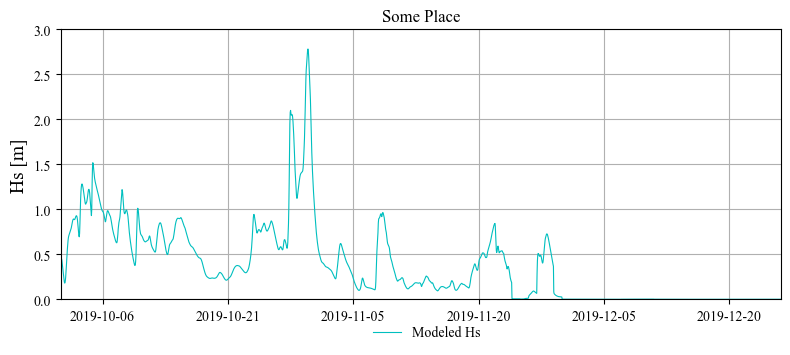

In [6]:
# plot parameters to initialize the plot
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(8,3))
ax = plt.axes([0,0.,0.9,.9])

# plot the modeled Hs over time
ax.plot(dt,ncfile.variables['swan_HS'][:,node_ids[0][0]],color='c',label='Modeled Hs',linewidth=0.8)

# adjust the parameters of the plot
ax.set_ylabel(r'Hs [m]',fontsize=14)
ax.set_ylim([0,3.000001])
ax.set_xlim([dt[0],dt[-1]])

ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(0.6, -.05),ncol=2,frameon=False,fontsize=10)
ax.set_title('Some Place')
ax.xaxis.set_major_locator(plt.MaxNLocator(8))

plt.show()

#### plot a map of the Hs at a specific time

In [7]:
# map boundary ------------------------------------------------------------------------
lat1,lat2 = 65,80
lon1,lon2 = -180, -130

# defining the time range I want
time1, time2 = np.datetime64('2019-11-24 21:00:00'),np.datetime64('2019-11-24 23:00:00')
# search for the nearest time to the time inputted
idx = np.where((time1 < dt.values) &\
               (dt.values < time2))[0][0]

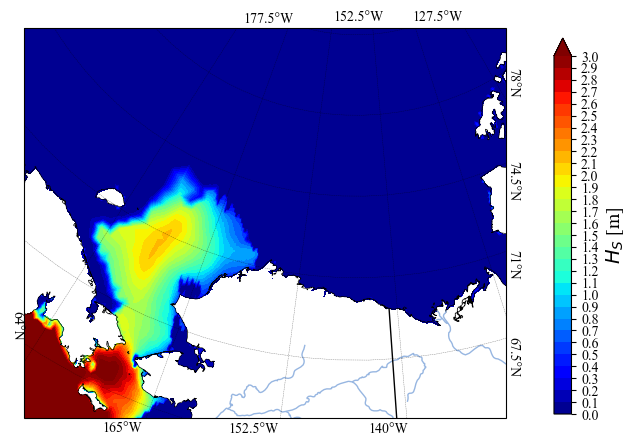

In [8]:
# plot parameters to initialize the plot
proj = ccrs.NorthPolarStereo(central_longitude=-145) # this data is in the arctic so we use the NorthPolarStereo projection
fig = plt.figure(figsize=(7,4))    
ax = plt.axes([0,0.,0.975,.975],projection=proj)
cmap = mpl.cm.get_cmap('jet')

# define countorus levels and colormap
levels = np.arange(0,3.1,0.1)


# plot the model data on a map
# this is a triangular grid so we need to define the triangles
# and we need to use tricontourf to plot the data
triang = tri.Triangulation(x,y, triangles=ncfile.variables['element'][:,:]-1)
Z = ncfile['swan_HS'][idx,:]
if Z.mask.any():
    point_mask_indices = np.where(Z.mask)
    tri_mask = np.any(np.in1d(ncfile.variables['element'][:,:]-1 , \
                              point_mask_indices).reshape(-1, 3), axis=1)
    triang.set_mask(tri_mask)
cf = ax.tricontourf(triang, Z,transform = ccrs.PlateCarree(),levels=levels, extend = 'max',cmap = cmap)


# map parameters to make it look nice 
ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m',linewidth=0.5)
ax.add_feature(cart.feature.RIVERS,linestyle="-")
ax.add_feature(cart.feature.BORDERS.with_scale("50m"),linestyle="-")
gl = ax.gridlines(xlocs=np.arange(-190,-100,12.5),ylocs=np.arange(-90,90,3.5),
                            draw_labels=True,linewidth=0.3, color="black", alpha=0.5,
                            y_inline=False,linestyle="--",zorder=20)
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.xlabel_style = {'rotation': 0}
gl.ylabels_left = False
gl.ylabels_right= True
gl.ylabel_style = {'rotation': -90}
gl.ypadding = 1.25
gl.xformatter = cart.mpl.gridliner.LONGITUDE_FORMATTER
gl.xpadding = 8

# add the colorbar
cbar_ax = fig.add_axes([.90,.0098,0.025,0.94])
cbar = fig.colorbar(cf,cax = cbar_ax, ticks=levels,orientation='vertical')
cbar.set_label(label = r'$H_{S}$ [m]',fontsize =14)

plt.show()